<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Трансформерная-архитектура-GPT">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Трансформерная архитектура GPT
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-символов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация символов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Построение-модели">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Построение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Обучение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Генерация-текста">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Архитектура GPT

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. [RNN с пословной токенизацией](RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](LSTM_unidirectional_BPE.ipynb)
4. [Двунаправленная LSTM](LSTM_bidirectional.ipynb)
5. Архитектура GPT (текущий файл)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
from typing import Tuple, List

import os
import random

import tensorflow as tf

from tensorflow.data import TextLineDataset, AUTOTUNE
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow import keras

from keras.utils import plot_model

import keras_nlp

from keras_nlp.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary
from keras_nlp.layers import StartEndPacker, TokenAndPositionEmbedding, TransformerDecoder
from keras_nlp.metrics import Perplexity
from keras_nlp.samplers import GreedySampler, BeamSampler, RandomSampler, TopKSampler, TopPSampler

from utils.useful_funcs import request_url, get_url_data, get_data

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Задание функции, разделяющей набор данных на выборки:

In [2]:
def train_test_split(text: list, test_size: float) -> Tuple[List[str], List[str]]:
    random.shuffle(text)
    threshold = int((1 - test_size) * len(text))
    
    train = text[:threshold]
    test = text[threshold:]
    
    return train, test

Задание функции, сохраняющей разделённые выборки в файлы:

In [3]:
def split_into_train_valid_test(text: str,
                                path_train: str,
                                path_valid: str,
                                path_test: str = None,
                                test_size: float = 0.25) -> None:
    
    if os.path.isfile(path_train) == False and os.path.isfile(path_valid) == False:
        
        text_split = [s.strip() for s in text.split('.')]
        
        train_text, valid_text = train_test_split(text_split, test_size)
        test_text = None
        
        if path_test != None:
            valid_text, test_text = train_test_split(valid_text, test_size)
            test_text = ' '.join(test_text)
        
        train_valid_test = [(path_train, train_text), (path_valid, valid_text), (path_test, test_text)]
        
        for (path, text) in train_valid_test:
            if path != None:
                with open(path, 'w', encoding='utf-8') as file:
                    file.write(' '.join(text))
        
        print('Splitted into:', len(train_text), 'train,', len(valid_text), 'valid and', 
              len(test_text) if test_text != None else 0, 'test')
    
    else:
        print('Files already exist')

---

Проверка наличия папки для хранения наборов данных:

In [4]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

Задание пути к файлу с основным набором данных:

In [5]:
path_file = 'data/hpmor.txt'

Формирование/загрузка набора данных в зависимости от его наличия:

In [6]:
try:
    with open(path_file, 'r', encoding='utf-8') as file:
        text = file.read()
    
    print('Uploaded from', path_file)
    
except:
    text = get_data('https://hpmor.ru/')
    
    with open(path_file, 'w', encoding='utf-8') as file:
        file.write(text)
    
    print('Saved to', path_file)

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [7]:
text[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов в тексте:

In [8]:
print('Всего слов:', len(text.split(' ')))

Всего слов: 559855


Задание путей до тренировочной и валидационной выборок:

In [9]:
path_train = 'data/hpmor_train.txt'
path_valid = 'data/hpmor_valid.txt'

Разделение текста на тренировочную и валидационную выборки:

In [10]:
split_into_train_valid_test(text, path_train, path_valid, test_size=0.25)

Files already exist


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Трансформерная архитектура GPT

Задание функции, разделяющей входящее значение на признаки и их

In [11]:
def preprocess(inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    
    return features, labels

---

### 3.1 Токенизация символов

Выведение на экран максимальной и минимальной длины предложений в тексте:

In [12]:
print('Максимальная длина строки:', len(max(text.split('.'), key=len).split()))
print('Минимальная длина строки:', len(min(text.split('.'), key=len).split()))

Максимальная длина строки: 217
Минимальная длина строки: 0


Задание констант:

In [13]:
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 450

EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000

Формирование датасетов:

In [14]:
train_dataset = (
    TextLineDataset(path_train)
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

valid_dataset = (
    TextLineDataset(path_valid)
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
)

Выведение на экран первого бартча тренировочного датасета:

In [15]:
list(train_dataset.as_numpy_iterator())[0][0].decode('utf-8')[:500]

'к нет смысла позволять врагу увидеть их раньше, чем они увидят его это идёт вразрез с твоими моральными принципами, что многократно перевешивает желание другой части тебя выиграть этот спор — извини на мгновение минерва вспомнила, как они с гарри гуляли в косом переулке — казалось, это было много-много лет назад — хотя, возможно, сам факт того, что тебе дали шоколад, уже считается за положительное подкрепление, тогда тебе, наверное, нужно положить его в карман или вроде того если ген б зависит о'

Формирование словаря:

In [16]:
vocabulary = compute_word_piece_vocabulary(
    train_dataset,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=['[PAD]', '[UNK]', '[BOS]'],
)

Выведение на экран общего числа слов:

In [17]:
print('Слов в словаре:', len(vocabulary))

Слов в словаре: 4926


Выведение на экран первых элементов словаря:

In [18]:
vocabulary[:10]

['[PAD]', '[UNK]', '[BOS]', '!', '#', '$', '%', '&', '(', ')']

Формирование словаря токенов:

In [19]:
tokenizer = WordPieceTokenizer(
    vocabulary=vocabulary,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

Добавление токена начала строки:

In [20]:
start_packer = StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id('[BOS]'),
)

Токенизация датасетов:

In [21]:
train = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
valid = valid_dataset.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

---

### 3.2 Построение модели

Задание формата трансформации:

In [22]:
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)

Преобразование слов в числа:

In [23]:
embedding_layer = TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)

Настройка трансформатора:

In [24]:
x = embedding_layer(inputs)

Настройка декодера:

In [25]:
for _ in range(NUM_LAYERS):
    decoder_layer = TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)

Задание формата выходных значений:

In [26]:
outputs = keras.layers.Dense(VOCAB_SIZE)(x)

Определение модели:

In [27]:
model = keras.Model(inputs=inputs, outputs=outputs)

Задание констант:

In [28]:
LOSS_F = SparseCategoricalCrossentropy(from_logits=True)
PERPLEX = Perplexity(from_logits=True, mask_token_id=0)

Компиляция модели:

In [29]:
model.compile(optimizer='adam', loss=LOSS_F, metrics=[PERPLEX])

Выведение на экран таблицы поведения параметров на слоях нейросети:

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        1312768   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_decoder (Transf  (None, None, 256)        394749    
 ormerDecoder)                                                   
                                                                 
 transformer_decoder_1 (Tran  (None, None, 256)        394749    
 sformerDecoder)                                                 
                                                                 
 dense (Dense)               (None, None, 5000)        128500

Проверка наличия папки для хранения изображений:

In [31]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

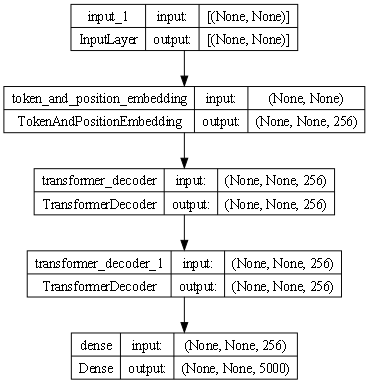

In [32]:
plot_model(model, 'images/gpt_arch.png', show_shapes=True, dpi=70)

---

### 3.3 Обучение модели

Обучение модели:

In [33]:
model.fit(train, validation_data=valid, verbose=2, epochs=100)

Epoch 1/100
1/1 - 5s - loss: 8.5320 - perplexity: 5074.7280 - val_loss: 8.3259 - val_perplexity: 4129.6021 - 5s/epoch - 5s/step
Epoch 2/100
1/1 - 1s - loss: 8.1976 - perplexity: 3632.2896 - val_loss: 8.1024 - val_perplexity: 3302.3901 - 1s/epoch - 1s/step
Epoch 3/100
1/1 - 1s - loss: 7.8769 - perplexity: 2635.5615 - val_loss: 7.8638 - val_perplexity: 2601.2939 - 1s/epoch - 1s/step
Epoch 4/100
1/1 - 1s - loss: 7.5731 - perplexity: 1945.1315 - val_loss: 7.6413 - val_perplexity: 2082.4795 - 1s/epoch - 1s/step
Epoch 5/100
1/1 - 1s - loss: 7.3038 - perplexity: 1485.8715 - val_loss: 7.4554 - val_perplexity: 1729.2208 - 1s/epoch - 1s/step
Epoch 6/100
1/1 - 1s - loss: 7.0715 - perplexity: 1177.9291 - val_loss: 7.3081 - val_perplexity: 1492.3735 - 1s/epoch - 1s/step
Epoch 7/100
1/1 - 1s - loss: 6.8700 - perplexity: 962.9338 - val_loss: 7.1932 - val_perplexity: 1330.3575 - 1s/epoch - 1s/step
Epoch 8/100
1/1 - 1s - loss: 6.6898 - perplexity: 804.1279 - val_loss: 7.1057 - val_perplexity: 1218.9543

Epoch 66/100
1/1 - 2s - loss: 0.4745 - perplexity: 1.6073 - val_loss: 7.7355 - val_perplexity: 2288.1272 - 2s/epoch - 2s/step
Epoch 67/100
1/1 - 2s - loss: 0.4489 - perplexity: 1.5666 - val_loss: 7.7649 - val_perplexity: 2356.4324 - 2s/epoch - 2s/step
Epoch 68/100
1/1 - 2s - loss: 0.4283 - perplexity: 1.5346 - val_loss: 7.8072 - val_perplexity: 2458.1204 - 2s/epoch - 2s/step
Epoch 69/100
1/1 - 2s - loss: 0.4058 - perplexity: 1.5005 - val_loss: 7.8234 - val_perplexity: 2498.2937 - 2s/epoch - 2s/step
Epoch 70/100
1/1 - 2s - loss: 0.3821 - perplexity: 1.4653 - val_loss: 7.8590 - val_perplexity: 2588.8345 - 2s/epoch - 2s/step
Epoch 71/100
1/1 - 2s - loss: 0.3615 - perplexity: 1.4355 - val_loss: 7.8883 - val_perplexity: 2665.8521 - 2s/epoch - 2s/step
Epoch 72/100
1/1 - 2s - loss: 0.3430 - perplexity: 1.4092 - val_loss: 7.9118 - val_perplexity: 2729.3298 - 2s/epoch - 2s/step
Epoch 73/100
1/1 - 2s - loss: 0.3280 - perplexity: 1.3881 - val_loss: 7.9612 - val_perplexity: 2867.5154 - 2s/epoch - 

---

### 3.4 Генерация текста

Задание функции, заполняющей тело запроса:

In [34]:
def next(prompt: tf.Tensor, 
         cache: tf.Tensor, 
         index: tf.Tensor) -> Tuple[tf.Tensor, None, Tuple]:
    
    logits = model(prompt)[:, index - 1, :]
    hidden_states = None
    
    return logits, hidden_states, cache

Задание функции предсказания следующего символа:

In [35]:
def predict_next(sampler: keras_nlp.samplers,
                 name: str,
                 prompt_tokens: tf.Tensor) -> str:
    
    tokens = sampler(
        next=next,
        prompt=prompt_tokens,
        index=1,
    )
    
    text = tokenizer.detokenize(tokens)
    
    print(f'{name.capitalize()} search generated text:')
    return text.numpy()[0].decode('utf-8')

---

Задание пустого тела запроса:

In [36]:
prompt_tokens = start_packer(tokenizer(['']))

Выведение на экран пустого тела запроса:

In [37]:
prompt_tokens

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

---

**Greedy search** - алгоритм подбора наиболее вероятного токена на каждом шаге.

Генерация текста:

In [38]:
predict_next(GreedySampler(), 'Greedy', prompt_tokens)

Greedy search generated text:


'[BOS] и учиться их заставим — сам салазар слизерин говорил , что маглорождённых надо изгнать ! что они ослабляют нашу кровь . . . — голос драко поднялся до крика возможно , дамблдор во многом ошибается , но он по крайней мере видит в учениках людей , а не животных , которых нужно держать в загоне , чтобы они не разбредались примем как гипотезу , что инструмент воскрешения — философский камень , спрятанный в зеркале . . . почему же дамблдор поставил зеркало в коридоре , куда проберётся даже п'

---

**Beam search** - алгоритм подбора наиболее вероятной последовательности на каждом шаге и лучшего токена среди всех последовательностей. 

Генерация текста:

In [39]:
predict_next(BeamSampler(num_beams=10), 'Beam', prompt_tokens)

Beam search generated text:


'[BOS] nihil supernum притормозите , — ответил гарри своим составляющим его глаза распахнулись , он в полном изумлении уставился на гарри и об этом грейнджер тоже знает точка джагсон резко махнул палочкой , и светящиеся верёвки метнули ханну к девочкам — совсем как в пьесе ! — вздохнула девушка с третьего курса — большинство людей — идиоты , перед которыми , тем не менее , тоже необходимо держать лицо тихие металлические позвякивания'

---

**Random search** - алгоритм подбора следующего наиболее вероятного токена, которым может оказаться любое слово из всего корпуса текста, на каждом шаге.

Генерация текста:

In [40]:
predict_next(RandomSampler(), 'Random', prompt_tokens)

Random search generated text:


'[BOS] 1202 н представь : кто - нибудь тебе говорит , что тебе насколько опасная магия для вас не ханна , он сдались намере он сневномк позш - ше — ты больше знаешь о магии , чтобы получить соглашным ничего не выражало по крайней мере , пока наществаных , которых нужно держать оченьтельность чувствуя , но всё , что было раньше . . . просто поставило тебя на то же место , как прось и фреду переломали рёбра ! близнецы лишь замотали головами — если я не уверен , что когда профессор защиты сбых дер'

---

**Top-K search** - алгоритм подбора следующего токена по вероятностному распределению, которое распределеяется между фиксированного числа топ-К наиболее вероятных токенов.

Генерация текста:

In [41]:
predict_next(TopKSampler(k=10), 'Top-K', prompt_tokens)

Top-k search generated text:


'[BOS] — невиллом лонгботтомом , ага — вас не волнует , насколько опасная магия для этого потребуется и ел пиздавали его таким , не позволяет гре ог покляни в самом начале этого года , когда распределяющая шляпа предложила тебе пуффендуй — я бы хотел назначить амелию боунс регентом по вопросам , что погибла моя мама , и будет жаль , мой лорд , в голову мысль , что следует определить условия прекроет глаза — мне кажется , сразиться следовательно , и'

---

**Top-P search** - алгоритм подбора следующего токена по вероятностному распределению, неравномерно распределённому среди наиболее вероятных токенов.

Генерация текста:

In [42]:
predict_next(TopPSampler(p=0.5), 'Top-P', prompt_tokens)

Top-p search generated text:


'[BOS] гарри джеймс поттер - эванс - веррес » уровень адреналина в крови начал расти по спине гарри пробежал холодок — в повседневном английском языке , мистер поттер , слово « друг » не ассоциируется с отчаянными попытками воскресить мёртвого это было бы полезно , это помогло бы в будущем вести себя более разумно — нет , ты не понимаешь , несмотря на то , что книги тебя предупредили , попросту не существует способа понять это , пока . . . — но ведь это не оста'

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

Были продемонстрированы результаты обучения построенной модели с применением различных алгоритмов поиска лучших токенов.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>